In [10]:
### this code plots rdf and radial profiles for displacement/contacts from text files produced by contacts_new.py ###

import matplotlib.pyplot as plt
import time
import numpy as np
from scipy import stats
start = time.time()


# function to calculate radial distribution function and contacts/displacement radial profile
def calc_rdf(n, x, y, z, dr, r_max, box_dim, box_shear):

    edges = np.arange(0., r_max, dr)  # edges of shells
    steps = len(edges) - 1  # number of shells
    radii = np.zeros(steps)  # radii of shells
    
    # volume of box
    box_vol = box_dim[0] * box_dim[1] * box_dim[2]
    ideal_density = n / box_vol  # density of ideal gas

    g = np.zeros([n, steps])
    for i in range(n):
        # distances from given particle to all others with periodic BC
        dx = (x[i] - x) - np.around((x[i] - x) / box_dim[0])  * box_dim[0]
        dy = (y[i] - y) - np.around((y[i] - y) / box_dim[1]) * box_dim[1]
        dz = (z[i] - z) - np.around((z[i] - z) / box_dim[2]) * box_dim[2]
        # correct for shear along xz
        dx -= np.around((z[i] - z) / box_dim[2]) * box_shear[1]
        # total distance between particles
        distances = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
        # sets distance of self very large to avoid counting
        distances[i] = r_max * 10
        # group distances into bins and form histogram
        (result, bins) = np.histogram(distances, bins=edges, normed=False)
        # normalise by average density of ideal gas with no interactions
        g[i, :] = result / ideal_density

# Average g(r) for all interior particles and compute radii
    g_average = np.zeros(steps)
    for i in range(steps):
        radii[i] = (edges[i] + edges[i + 1]) / 2.  # average radius of shell
        rOuter = edges[i + 1]  # outer shell radius
        rInner = edges[i]  # inner shell radius
        # average g(r) over all particles in given shell and normalise by volume of shell
        g_average[i] = np.mean(g[:, i]) / (4.0 / 3.0 * np.pi * (rOuter ** 3 - rInner ** 3))

    return g_average, radii



### code to be executed ###

figure_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test/Plots'
data_path = 'old_data'
files = ['A1B1C1D1.dump']

dr = 0.2  # thickness of shells of rdf
r_max = 15.0  # maximum shell thickness for rdf
g = []  # radial distribution function
r = []  # radial distance from given particle

for i in range(len(files)):
    file = files[i]
    timesteps = []

# reads the datafile and stores relevant data in arrays
    with open('%s/%s' % (data_path, file)) as f:
        raw = f.readlines()
        f.close()
    raw = ([x.strip() for x in raw])
    nt = raw.count('ITEM: TIMESTEP')  # number of entries in data file (timesteps)
    n = int(raw[3].split()[0])  # number of particles
    
    #original_bounds = []
    #for q in range(5, 8):
        #original_bounds.append(list(map(float, raw[q].split())))
    #box_dim = np.array(original_bounds)[:, 1]
    
    ts = [1, 15, 31]
    #ts = [61, 47, 33]
    for t in ts:
        x = []; y = []; z = []
        box_bounds = []
        for i in range(n+9):
            index = i + t * (n + 9)
        # reads the timestep
            if i == 1:
                timestep = int(raw[index])
                timesteps.append(timestep)
        
        # reads box boundaries
            if 5 <= i < 8:
                box_bounds.append(list(map(float, raw[index].split())))

        # discards first nine lines and split each line into a list of floats
            if i > 8:
                data = list(map(float, raw[index].split()))
                x.append(data[1])
                y.append(data[2])
                z.append(data[3])
        
        box_bounds = np.array(box_bounds)
        # box shear [xy xz yz]
        box_shear = box_bounds[:, -1]
        # box dimensions [lx ly lz]
        xlo = box_bounds[0][0] - min(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
        xhi = box_bounds[0][1] - max(0.0, box_shear[0], box_shear[1], box_shear[0] + box_shear[1])
        ylo = box_bounds[1][0] - min(0.0, box_shear[2])
        yhi = box_bounds[1][1] - max(0.0, box_shear[2])
        zlo = box_bounds[2][0]
        zhi = box_bounds[2][1]
        box_dim = np.array([xhi - xlo, yhi - ylo, zhi - zlo])
        
        print(box_dim)
        print(box_shear)

        x = np.array(x)
        y = np.array(y)
        z = np.array(z)

        g_i, r_i = calc_rdf(n, x, y, z, dr, r_max, box_dim, box_shear)
        g.append(g_i)
        r.append(r_i)

end = time.time()
print('Time: %f s' % (end-start))

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test/old_data/A1B1C1D1.dump'

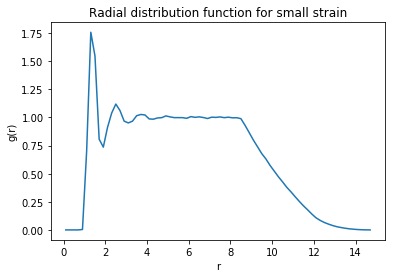

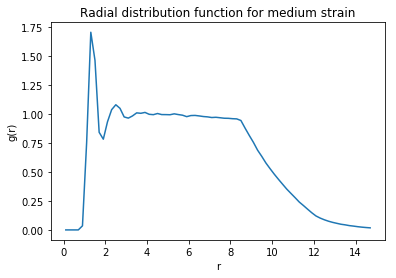

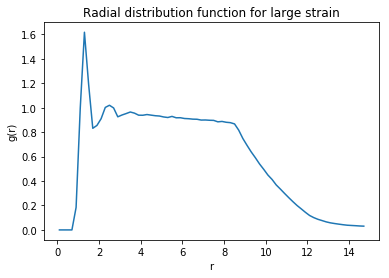

In [12]:
plt.figure()
plt.plot(r[0], g[0])
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution function for small strain')
plt.savefig('%s/rdf_test_small_strain.png' % figure_path)
#plt.savefig('%s/rdf_small_strain_no_correction.png' % figure_path)

plt.figure()
plt.plot(r[1], g[1])
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution function for medium strain')
plt.savefig('%s/rdf_test_medium_strain.png' % figure_path)
#plt.savefig('%s/rdf_medium_strain_no_correction.png' % figure_path)

plt.figure()
plt.plot(r[2], g[2])
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution function for large strain')
plt.savefig('%s/rdf_test_large_strain.png' % figure_path)
#plt.savefig('%s/rdf_large_strain_no_correction.png' % figure_path)

plt.show()